# Introduction
In `3. Part of Speech Tagging - Second attempt with RNN` I did Part of Speech (POS) tagging with several RNN's. My most successful was inspired by [Wang et al., 2015](https://arxiv.org/pdf/1510.06168.pdf), who used a model originally from [Graves, 2012](https://www.cs.toronto.edu/~graves/preprint.pdf):
Two LSTM layers with 93 hidden units, one doing a forward pass of the input and the other a backward pass. 

I encoded all words using word embeddings trained by [Glove](https://nlp.stanford.edu/projects/glove/). Glove is Stanfords embedding model.

In this notebook I will use a similar approach, but this time I will implement my model in PyTorch. Hopefully increased control will help me to learn an experiment.

# The data
I will be using the same training data for my tagger as in all my previous notebooks:
[Universal Dependencies - English Web Treebank](http://universaldependencies.org/treebanks/en_ewt/index.html), a CoNLL-U formart corpus with 254 830 words and 16 622 sentences in english *taken from various web media including weblogs, newsgroups, emails, reviews, and Yahoo! answers*.

## Load the Data
First lets load the training data and convert it to a python dictionary.
I use the [conllu](https://github.com/EmilStenstrom/conllu) python package to parse the CoNLL-U files to dictionaries.

In [1]:
import numpy as np
import conllu
import torch

Read the data.

In [2]:
directory = 'UD/UD_English-EWT'
with open('{}/en_ewt-ud-train.conllu'.format(directory), 'r', encoding='utf-8') as f:
    train_text = f.read()
    
directory = 'UD/UD_English-EWT'
with open('{}/en_ewt-ud-dev.conllu'.format(directory), 'r', encoding='utf-8') as f:
    dev_text = f.read()
    
directory = 'UD/UD_English-EWT'
with open('{}/en_ewt-ud-test.conllu'.format(directory), 'r', encoding='utf-8') as f:
    test_text = f.read()

Convert it to a dictionary.

In [3]:
train_dict = conllu.parse(train_text)
dev_dict = conllu.parse(dev_text)
test_dict = conllu.parse(test_text)

Count sentences and tokens.

In [4]:
from functools import reduce

n_train_sentences = len(train_dict)
n_train_tokens = reduce(lambda x, y: x + len(y), train_dict, 0)

print("The training set contains {} sentences and {} tokens".format(n_train_sentences, n_train_tokens))

The training set contains 12543 sentences and 204607 tokens


In [5]:
train_sentences = [[token['form'] for token in sentence] for sentence in train_dict]
train_labels = [[token['upostag'] for token in sentence] for sentence in train_dict]

dev_sentences = [[token['form'] for token in sentence] for sentence in dev_dict]
dev_labels = [[token['upostag'] for token in sentence] for sentence in dev_dict]

test_sentences = [[token['form'] for token in sentence] for sentence in test_dict]
test_labels = [[token['upostag'] for token in sentence] for sentence in test_dict]

In [6]:
pos_tags = list(set(reduce(lambda x, y: x + y, train_labels)))

In [7]:
n_labels = len(pos_tags)
n_labels

17

# Feature Engineering
[Wang et al.](https://arxiv.org/pdf/1510.06168.pdf) showed that a bidirectional LSTM network could achieve state of the art performance without using any morphological features, they only used these features:
* Word embedding of the word (cast to lower case). Embeddings trained by the same architecture, but on another task.
* Suffix of length two, one-hot encoded
* Wether the word is all caps, lower case, or has an initial capital letter. One-hot encoded.

Other papers, like [Xiao et al.](https://arxiv.org/abs/1809.01997), complement word embeddings with character embeddings. 
It would be interesting to experiment with this.

## Glove
I will opt to use the 100 dimensional Glove 6B data. My vocabulary will be exactly the words inside the pretrained model.

In [8]:
glove_path = 'glove/glove.6B/glove.6B.100d.txt'
embeddings = {}
token_index = {}
index_token = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        tok, *vec = line.split()
        embeddings[tok] = np.array(vec, dtype='float32')
        # Reserve index 0 for padding
        token_index[tok] = i + 1
        index_token[i+1] = tok

I know from my last notebook that my data has many words that are OOV for Glove. I adressed this by pre-processing my data. In this notebook I will condense my preprocessing to a single method, check the other one for more rationale on why I apply each step.

I will apply pre-processing to all three data sets: train, dev and test. As the preprocessing is not trained on the data this could be done on new data in production as well.

In [9]:
import re
def allign_to_vocab(vocab, sentences):
    
    # Find all OOV tokens
    oov = find_oov(vocab, sentences)
    print("%d OOV tokens before processing" % len(oov))
    
    # Convert to lower case
    sentences = [[token.lower() for token in sentence] for sentence in sentences]
    
    oov = find_oov(vocab, sentences)
    print("%d OOV tokens after converting to lower case" % len(oov))
    
    # Replace URL's with 'url'
    sentences = [[convert_url(token) for token in sentence] for sentence in sentences]
    
    oov = find_oov(vocab, sentences)
    print("%d OOV tokens after converting urls" % len(oov))
    
    # Build spelling correction dictionary
    # Search for word in vocabulary words within 1 Levensthein Damerau distance
    new_spelling = dict([(word, find_one_neighbour(word, embeddings)) for word in oov])
    sentences = [[new_spelling[token] if token in new_spelling else token for token in sentence] for sentence in sentences]
    
    oov = find_oov(vocab, sentences)
    print("%d OOV tokens after spelling correction" % len(oov))
    
    # Replace OOV words with 'unk'
    # See https://stackoverflow.com/questions/49239941/what-is-unk-in-glove-6b-50d-txt
    sentences = [['unk' if token in oov else token for token in sentence] for sentence in sentences]
    
    return sentences

def find_oov(vocab, sentences):
    oov = []
    for sentence in sentences:
        for tok in sentence:
            if tok not in vocab:
                oov.append(tok)
    return oov
     
def convert_url(token):
    # Match words starting with www., http:// or https://
    if re.match(r'^(?:https{0,1}\:\/\/.*|www\.*)', token):
        return "url"
    else:
        return token

# Checks for vocabulary words within 1 Damerau Levenstein distance and returns the first match
# Logic inspired by http://norvig.com/spell-correct.html
def find_one_neighbour(word, vocab):
    
    ascii_vocab = [str(chr(i)) for i in range(32, 127)]
    
    # Tuples with all possible splits of word
    splits = [(word[:i], word[i:]) for i in range(len(word))]
    
    # All words generated by deleting one character
    for L, R in splits:
        candidate = L + R[1:] if R else None
        if candidate in vocab:
            return candidate
    # All words generated by swapping two characters in word
    for L, R in splits:
        candidate = L + R[1:] if R else None
        if candidate in vocab:
            return candidate
    # All words generated by swapping two characters in word
    for L, R in splits:    
        candidate = L + R[1] + R[0] + R[2:] if len(R) > 1 else None
        if candidate in vocab:
            return candidate
    # All words generated by inserting a character in word
    for L, R in splits:
        for c in ascii_vocab:    
            candidate = L + c + R 
            if candidate in vocab:
                return candidate
    # All words generated by replacing a character in word
    for L, R, in splits:
        for c in ascii_vocab:    
            candidate = L + c +R[1:] if R else None
            if candidate in vocab:
                return candidate
        
    return word
    

In [10]:
%%time
print("Training set:")
train_sentences = allign_to_vocab(embeddings, train_sentences)

print("\nDev set:")
dev_sentences = allign_to_vocab(embeddings, dev_sentences)

print("\nTest set:")
test_sentences = allign_to_vocab(embeddings, test_sentences)

Training set:
31192 OOV tokens before processing
2442 OOV tokens after converting to lower case
2310 OOV tokens after converting urls
1066 OOV tokens after spelling correction

Dev set:
4362 OOV tokens before processing
463 OOV tokens after converting to lower case
424 OOV tokens after converting urls
215 OOV tokens after spelling correction

Test set:
4589 OOV tokens before processing
522 OOV tokens after converting to lower case
483 OOV tokens after converting urls
267 OOV tokens after spelling correction
Wall time: 8.92 s


## Encoding the data
I will encode the targets and the tokens as integers.

### Labels
First build a map from pos tag to an index. Reserve 0 for Padding.

In [11]:
pos_tag_index = {}
for i, pos in enumerate(pos_tags):
    pos_tag_index[pos] = i + 1

In [12]:
Y_train = [torch.from_numpy(np.asarray([pos_tag_index[pos] for pos in sentence])).long()  for sentence in train_labels]
Y_dev = [torch.from_numpy(np.asarray([pos_tag_index[pos] for pos in sentence])).long()  for sentence in dev_labels]
Y_test = [torch.from_numpy(np.asarray([pos_tag_index[pos] for pos in sentence])).long()  for sentence in test_labels]

### Tokens
I already built the mapping from token to index. I also replaced all OOV tokens with `unk`, so all words will be in the vocabulary. 

In [13]:
X_train = [torch.from_numpy(np.asarray([token_index[tok] for tok in sentence])).long() for sentence in train_sentences]
X_dev = [torch.from_numpy(np.asarray([token_index[tok]  for tok in sentence])).long()  for sentence in dev_sentences]
X_test = [torch.from_numpy(np.asarray([token_index[tok] for tok in sentence])).long()  for sentence in test_sentences]

## Padding the data

In [17]:
import torch.nn as nn

In [27]:
class PaddedGenerator():
    def __init__(self, x_set, y_set = None, batch_size = 126):
        
        if y_set:
            self.has_label = True
        else:
            self.has_label = False
            
        self.batch_size = batch_size
        if self.has_label:
            self.x, self.y, self.sequence_lengths = [], [], []
        else:
            self.x, self.sequence_lengths = [], []
        # Pad Data so all batches have sequences of equal length
        for idx in range(int(np.ceil(len(x_set) / float(self.batch_size)))):
            batch_x = x_set[idx * self.batch_size:(idx + 1) * self.batch_size]
            
            # The input is sorted so the first sequence is the longest
            max_len = len(batch_x[0])
            batch_sequence_lengths = torch.Tensor(list(map(len, batch_x))).int()
            batch_x = nn.utils.rnn.pad_sequence(batch_x, batch_first=True)
            
            self.x.append(batch_x)
            self.sequence_lengths.append(batch_sequence_lengths)
            
            if self.has_label:
                batch_y = y_set[idx * self.batch_size:(idx + 1) * self.batch_size]
                batch_y = nn.utils.rnn.pad_sequence(batch_y, batch_first=True)
                self.y.append(batch_y)
            
            
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        if self.has_label:
            return self.x[idx], self.y[idx], self.sequence_lengths[idx]
        else:
            return self.x[idx], self.sequence_lengths[idx]

First I sort the sequences according to length, and then dicide them in bataches where they are padded to be of equal length within the batch.

In [24]:
X_train = sorted(X_train, reverse=True, key=len)
Y_train = sorted(Y_train, reverse=True, key=len)

X_dev = sorted(X_dev, reverse=True, key=len)
Y_dev = sorted(Y_dev, reverse=True, key=len)

X_test = sorted(X_test, reverse=True, key=len)
Y_test = sorted(Y_test, reverse=True, key=len)

In [29]:
train_padded = PaddedGenerator(X_train, Y_train, batch_size=126)
dev_padded = PaddedGenerator(X_dev, Y_dev, batch_size=126)
test_padded = PaddedGenerator(X_test, batch_size=126)

# RNN

## Embedding Layer
Create a frozen embedding layer from the Glove data.

In [30]:
import torch

Load the data into a tensor.

In [31]:
embedding_dims = 100
embedding_matrix = torch.from_numpy(np.array(list(embeddings.values())))
n_words = len(embedding_matrix)

Create a frozen embedding layer.

In [32]:
import torch.nn as nn

In [33]:
def create_embeddings(weights, frozen=True):
    
    embedding_layer = nn.Embedding(*weights.shape, _weight=embedding_matrix)
    embedding_layer.weight.requires_grad = frozen
    
    return embedding_layer

In [34]:
embedding_layer = create_embeddings(embedding_matrix)

## BLSTM 1
Let's implement the BLSTM introduced by Graves, with our Glove embeddings as the first layer.

In [35]:
import torch.nn.functional as F

In [36]:
class BLSTM1(nn.Module):
    def __init__(self, lstm_dim, n_classes, embedding_weights):
        super(BLSTM1, self).__init__()
        
        # Variables
        self.lstm_dim = lstm_dim
        self.vocab_size, self.embedding_dim = embedding_weights.shape
        self.n_classes = n_classes
        
        # Layers
        self.embedding = create_embeddings(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_dim, lstm_dim, batch_first=True, bidirectional=True)
        self.output = nn.Linear(self.lstm_dim * 2, self.n_classes + 1)
        
    def forward(self, padded_batch, sequence_lengths):
        
        # Embeddings
        embedded = self.embedding(padded_batch)#.unsqueeze(0)
        
         # Pack Padded Batch
        total_length = padded_batch.size(1)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, batch_first=True, lengths=sequence_lengths)
        
        # LSTM
        out, _ = self.lstm(packed_embedded)
        
        # Reverse Packing
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True, total_length=total_length)
        
        # Fully Connected
        out = F.log_softmax(self.output(out), 2)
        return out
        

In [38]:
import torch.optim as optim

In [37]:
blstm1 = BLSTM1(96, n_labels, embedding_matrix)

criterion = nn.NLLLoss(ignore_index=0)
optimizer = optim.Adam(blstm1.parameters())

In [40]:
from tqdm import tqdm

# Function inspired by https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, train_generator, optimizer, criterion, dev_generator=None, epochs = 2):
    
    # Only enter the validation state if there is a validation_loader
    phases = ['train']
    data_dict = {'train' : train_generator} 
    if dev_generator:
        phases.append('val')
        data_dict['val'] = dev_generator
        
    for epoch in range(epochs):
        
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)

        for phase in phases:
            
            data = data_dict[phase]
            
            # Only update model weights based on the training data
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            words_processed = 0
            
            for seq, labels, sequence_lengths in tqdm(data, total = len(data)):
                
                
                #labels = torch.autograd.Variable(labels).type(torch.LongTensor)

                optimizer.zero_grad()
                
                # Only track history during training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(seq, sequence_lengths)
                    loss = criterion(outputs.view(-1, n_labels + 1), labels.view(-1))
                    predictions = torch.argmax(outputs, dim=2)
                    
                    # Only perform backpropagation during training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # Save statistics
                running_loss += loss.item() * torch.sum(sequence_lengths).item()
                # Only count correct classifications when the label is not padding
                running_corrects += torch.sum((predictions == labels.data) * (labels.data != 0))
                words_processed += torch.sum(sequence_lengths)
                
                #return predictions, labels, words_processed
                
            epoch_loss = running_loss / words_processed.item()
            epoch_acc = running_corrects.item() / words_processed.item()
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
                
            

In [362]:
train_model(blstm1, train_padded, optimizer, criterion, dev_padded)

Epoch 1/2
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


train Loss: 1.9682 Acc: 0.4418


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.81it/s]


val Loss: 2.2596 Acc: 0.3310
Epoch 2/2
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]


train Loss: 0.7649 Acc: 0.7754


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.22it/s]


val Loss: 0.5118 Acc: 0.8401


In [363]:
train_model(blstm1, train_padded, optimizer, criterion, dev_padded, epochs=5)

Epoch 1/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


train Loss: 0.3798 Acc: 0.8869


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.38it/s]


val Loss: 0.4255 Acc: 0.8665
Epoch 2/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


train Loss: 0.2907 Acc: 0.9137


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.76it/s]


val Loss: 0.3846 Acc: 0.8813
Epoch 3/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


train Loss: 0.2355 Acc: 0.9294


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.84it/s]


val Loss: 0.3750 Acc: 0.8860
Epoch 4/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


train Loss: 0.1992 Acc: 0.9403


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.89it/s]


val Loss: 0.3761 Acc: 0.8892
Epoch 5/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


train Loss: 0.1728 Acc: 0.9489


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.76it/s]


val Loss: 0.3810 Acc: 0.8915


In [364]:
train_model(blstm1, train_padded, optimizer, criterion, dev_padded, epochs=5)

Epoch 1/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


train Loss: 0.1524 Acc: 0.9552


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.62it/s]


val Loss: 0.3856 Acc: 0.8940
Epoch 2/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


train Loss: 0.1358 Acc: 0.9602


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.13it/s]


val Loss: 0.3891 Acc: 0.8957
Epoch 3/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


train Loss: 0.1219 Acc: 0.9643


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.92it/s]


val Loss: 0.3921 Acc: 0.8978
Epoch 4/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


train Loss: 0.1101 Acc: 0.9680


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.10it/s]


val Loss: 0.3951 Acc: 0.8990
Epoch 5/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


train Loss: 0.0998 Acc: 0.9711


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.27it/s]


val Loss: 0.3992 Acc: 0.8999


In [366]:
torch.save(blstm1.state_dict(), 'pytorch_models/blstm1.pt')

Similar results as my last BLSTM with a validation accuracy around 90%. Training accuracy is 97% though, so the network is clearly overfitting.

It would be interesting to try using a GRU instead of LSTM, apply some regularization like Dropout, and perhaps experiment with character level features.

## BLSTM Two
Let's start by adding some regularization.

In [45]:
class BLSTM2(nn.Module):
    def __init__(self, lstm_dim, n_classes, embedding_weights, dropout_p=0.0):
        super(BLSTM2, self).__init__()
        
        # Variables
        self.lstm_dim = lstm_dim
        self.vocab_size, self.embedding_dim = embedding_weights.shape
        self.n_classes = n_classes
        self.dropout_p = dropout_p
        
        # Layers
        self.embedding = create_embeddings(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_dim, lstm_dim, batch_first=True, bidirectional=True)
        self.output = nn.Linear(self.lstm_dim * 2, self.n_classes + 1)
        self.dropout = nn.Dropout(p=self.dropout_p)
        
    def forward(self, padded_batch, sequence_lengths):
        
        # Embeddings
        embedded = self.embedding(padded_batch)
        
         # Pack Padded Batch
        total_length = padded_batch.size(1)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, batch_first=True, lengths=sequence_lengths)
        
        # LSTM
        out, _ = self.lstm(packed_embedded)
        
        # Reverse Packing
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True, total_length=total_length)
        
        # Dropout
        out = self.dropout(out)
        
        # Fully Connected
        out = F.log_softmax(self.output(out), 2)
        return out
        

In [46]:
blstm2 = BLSTM2(96, n_labels, embedding_matrix, dropout_p=.5)
criterion = nn.NLLLoss(ignore_index=0)
optimizer = optim.Adam(blstm2.parameters())

In [47]:
train_model(blstm2, train_padded, optimizer, criterion, dev_padded, 5)

Epoch 1/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


train Loss: 2.2492 Acc: 0.3145


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.03it/s]


val Loss: 3.0377 Acc: 0.3035
Epoch 2/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


train Loss: 1.3714 Acc: 0.6114


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.78it/s]


val Loss: 0.8420 Acc: 0.7279
Epoch 3/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


train Loss: 0.7062 Acc: 0.7831


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.22it/s]


val Loss: 0.5918 Acc: 0.8121
Epoch 4/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


train Loss: 0.5078 Acc: 0.8448


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.04it/s]


val Loss: 0.4728 Acc: 0.8471
Epoch 5/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


train Loss: 0.3893 Acc: 0.8817


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.55it/s]


val Loss: 0.4114 Acc: 0.8677


In [48]:
train_model(blstm2, train_padded, optimizer, criterion, dev_padded, 5)

Epoch 1/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


train Loss: 0.3135 Acc: 0.9056


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.05it/s]


val Loss: 0.3919 Acc: 0.8768
Epoch 2/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/it]


train Loss: 0.2641 Acc: 0.9202


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.88it/s]


val Loss: 0.3763 Acc: 0.8843
Epoch 3/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


train Loss: 0.2278 Acc: 0.9316


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.04it/s]


val Loss: 0.3754 Acc: 0.8880
Epoch 4/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


train Loss: 0.2025 Acc: 0.9398


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.08it/s]


val Loss: 0.3747 Acc: 0.8916
Epoch 5/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


train Loss: 0.1815 Acc: 0.9460


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.08it/s]


val Loss: 0.3760 Acc: 0.8938


Validation performance is now closer to training performance, but the network is still overfitting. Let's try reducing the network size.

In [51]:
blstm3 = BLSTM2(64, n_labels, embedding_matrix, dropout_p=.5)
criterion = nn.NLLLoss(ignore_index=0)
optimizer = optim.Adam(blstm3.parameters())

In [52]:
train_model(blstm3, train_padded, optimizer, criterion, dev_padded, 5)

Epoch 1/5
----------



  5%|████                                                                              | 5/100 [00:08<02:44,  1.73s/it]
Exception in thread Thread-29:
Traceback (most recent call last):
  File "C:\Users\Gustav\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Gustav\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Gustav\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


train Loss: 2.1062 Acc: 0.4166


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.93it/s]


val Loss: 1.3512 Acc: 0.5328
Epoch 2/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


train Loss: 0.6237 Acc: 0.8310


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.46it/s]


val Loss: 0.4174 Acc: 0.8764
Epoch 3/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


train Loss: 0.2972 Acc: 0.9208


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.41it/s]


val Loss: 0.3768 Acc: 0.8872
Epoch 4/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


train Loss: 0.2326 Acc: 0.9354


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.96it/s]


val Loss: 0.3680 Acc: 0.8917
Epoch 5/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


train Loss: 0.2004 Acc: 0.9431


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.83it/s]


val Loss: 0.3689 Acc: 0.8935


Training accuracy goes up much faster with a thinner network. Hmm?
After 5 epochs the train and validation accuracy are the same as they were after 10 with the wider network. 

Regardless, I feel like it is a problem that validation accuracy stagnates around 90%. Perhaps just using word embeddings as features is not enough to generalise well?

Let's try adding character features! I know that prefixes and suffixes of different lengths can be very potent features, so let's add those!

# Character level features
Let's start by adding one hot encoded versions of knows suffixes and prefixes. I think suffixes are the most important, so I'll go with prefixes of length one, and suffixes of length two and three.

In [357]:
class SuffixVocab():
    def __init__(self, sentences, gram_length, threshhold_to_index = 1, suffix=True):
        self.gram_length = gram_length
        self.gram_counts = {}
        self.suffix = suffix
        
        for sentence in sentences:
            for word in sentence:
                if len(word) < gram_length:
                    continue
                if suffix:
                    gram = word[-gram_length:]
                else:
                    gram = word[:gram_length]
                
                try:
                    self.gram_counts[gram] += 1
                except KeyError:
                    self.gram_counts[gram] = 1
        
        self.index_trim_vocab(threshhold_to_index)
        
        self.build_one_hot_dict()
                    
    def index_trim_vocab(self, threshhold = 1):
        self.gram2index = {}
        self.n_grams = 0
        for gram, occurences in self.gram_counts.items():
            if occurences >= threshhold:
                self.gram2index[gram] = self.n_grams
                self.n_grams += 1
                
    def build_one_hot_dict(self):
        self.gram2onehot = {}
        for gram, index in self.gram2index.items():
            
            # Build one hot vector
            onehot = torch.zeros(self.n_grams, dtype=torch.long)
            onehot[index] = 1.
            
            self.gram2onehot[gram] = onehot
    
    def word2onehot(self, word):
        if len(word) < self.gram_length:
            return torch.zeros(self.n_grams, dtype=torch.long)
        
        try:
            if self.suffix:
                return self.gram2onehot[word[-self.gram_length:]]
            else:
                return self.gram2onehot[word[:self.gram_length]]
        except KeyError:
            return torch.zeros(self.n_grams, dtype=torch.long)
            


## Suffixes of length two

In [358]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [359]:
suffix2 = SuffixVocab(train_sentences, 2, threshhold_to_index=20)

In [360]:
suffix2_df = pd.DataFrame(np.asarray([list(suffix2.gram_counts.keys()), list(suffix2.gram_counts.values())]).T , columns=['suffix', 'count'])
suffix2_df['count'] = suffix2_df['count'].astype(int)

In [361]:
suffix2_df = suffix2_df.sort_values('count', ascending=False)

In [362]:
suffix2_df.head()

,suffix,count
7,he,10194
63,nd,6416
25,to,5415
17,ng,5400
3,ed,5362


In [363]:
x = np.linspace(1, 100)
y = np.array([(suffix2_df['count'] >= i).sum() for i in x])

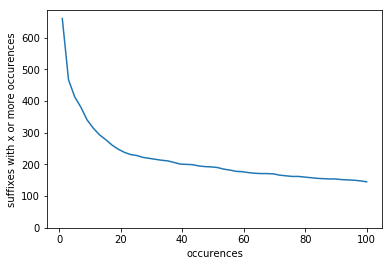

In [364]:
f = plt.plot(x, y)
ax = f[0].axes
ax.set_ylim([0, None])
ax.set_ylabel('suffixes with x or more occurences')
ax.set_xlabel('occurences')

Let's restrict our vocab to suffixes that occur at least 20 times. This significantly reduces the number of suffixes we track.

In [365]:
print("%d suffixes after trimming" %suffix2.n_grams)

248 suffixes after trimming


## Suffixes of length three

In [366]:
suffix3 = SuffixVocab(train_sentences, 3, threshhold_to_index=20)

In [367]:
suffix3_df = pd.DataFrame(np.asarray([list(suffix3.gram_counts.keys()), list(suffix3.gram_counts.values())]).T , columns=['suffix', 'count'])
suffix3_df['count'] = suffix3_df['count'].astype(int)

In [368]:
suffix3_df = suffix3_df.sort_values('count', ascending=False)

In [369]:
suffix3_df.head()

,suffix,count
7,the,9082
66,and,5335
16,ing,5039
28,hat,2487
61,you,2156


In [370]:
x = np.linspace(1, 100)
y = np.array([(suffix3_df['count'] >= i).sum() for i in x])

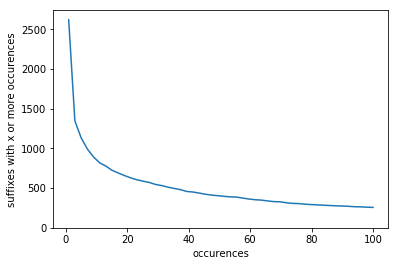

In [371]:
f = plt.plot(x, y)
ax = f[0].axes
ax.set_ylim([0, None])
ax.set_ylabel('suffixes with x or more occurences')
ax.set_xlabel('occurences')

Let's restrict our vocab to suffixes that occur at least 20 times. This significantly reduces the number of suffixes we track.

In [372]:
print("%d suffixes after trimming" %suffix3.n_grams)

658 suffixes after trimming


## Prefix of Length Two

In [373]:
prefix2 = SuffixVocab(train_sentences, 2, threshhold_to_index=20, suffix=False)

In [374]:
prefix2_df = pd.DataFrame(np.asarray([list(prefix2.gram_counts.keys()), list(prefix2.gram_counts.values())]).T , columns=['suffix', 'count'])
prefix2_df['count'] = prefix2_df['count'].astype(int)

In [375]:
prefix2_df = prefix2_df.sort_values('count', ascending=False)

In [376]:
prefix2_df.head()

,suffix,count
8,th,16781
7,an,6583
13,to,6041
12,in,4882
14,of,4040


In [377]:
x = np.linspace(1, 100)
y = np.array([(prefix2_df['count'] >= i).sum() for i in x])

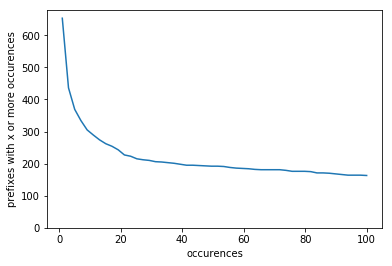

In [378]:
f = plt.plot(x, y)
ax = f[0].axes
ax.set_ylim([0, None])
ax.set_ylabel('prefixes with x or more occurences')
ax.set_xlabel('occurences')

Let's restrict our vocab to suffixes that occur at least 20 times. This significantly reduces the number of suffixes we track.

In [379]:
print("%d prefixes after trimming" %prefix2.n_grams)

243 prefixes after trimming


I ended up with a 1000 new dimensions in my input data. Perhpas I should represent the character level features in another way, such as encoding every character individually.

## Convert Data Sets
I'll need to feed these new tensors as input to my model as well. I could map word indexes to prefixes and suffixes, but that would not be possible for OOV words, so I will compute them directly on the input data.

In [388]:
def sentences2features(sentences):
    return [torch.cat(
            [torch.cat([
                torch.LongTensor([token_index[tok]]),
                prefix2.word2onehot(tok),
                suffix2.word2onehot(tok),
                suffix3.word2onehot(tok)]
            ).unsqueeze(0) for tok in sentence])
            for sentence in sentences]

In [389]:
X_train = sentences2features(train_sentences)
X_dev = sentences2features(dev_sentences)
X_test = sentences2features(test_sentences)

In [391]:
X_train = sorted(X_train, reverse=True, key=len)
Y_train = sorted(Y_train, reverse=True, key=len)

X_dev = sorted(X_dev, reverse=True, key=len)
Y_dev = sorted(Y_dev, reverse=True, key=len)

X_test = sorted(X_test, reverse=True, key=len)
Y_test = sorted(Y_test, reverse=True, key=len)

Let's reduce batch size now that we have much larger data points.

In [417]:
train_padded = PaddedGenerator(X_train, Y_train, batch_size=64)
dev_padded = PaddedGenerator(X_dev, Y_dev, batch_size=64)
test_padded = PaddedGenerator(X_test, batch_size=64)

# BLSTM with Suffixes and Prefixes

In [406]:
class BLSTMGrams(nn.Module):
    def __init__(self, lstm_dim, n_classes, embedding_weights, gram_features, dropout_p=0.0):
        super(BLSTMGrams, self).__init__()
        
        # Variables
        self.lstm_dim = lstm_dim
        self.vocab_size, self.embedding_dim = embedding_weights.shape
        self.n_classes = n_classes
        self.dropout_p = dropout_p
        self.gram_features = gram_features
        
        # Layers
        self.embedding = create_embeddings(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_dim + self.gram_features, lstm_dim, batch_first=True, bidirectional=True)
        self.output = nn.Linear(self.lstm_dim * 2, self.n_classes + 1)
        self.dropout = nn.Dropout(p=self.dropout_p)
        
    def forward(self, padded_batch, sequence_lengths):
        
        # Embeddings
        embedded = self.embedding(padded_batch[:,:,0])
        
        # One hot encoded grams
        grams = padded_batch[:,:,1:].float()
        
        # Combine embeddings and grams
        encoded = torch.cat([embedded, grams], 2)
        
        
         # Pack Padded Batch
        total_length = padded_batch.size(1)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(encoded, batch_first=True, lengths=sequence_lengths)
        
        # LSTM
        out, _ = self.lstm(packed_embedded)
        
        # Reverse Packing
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True, total_length=total_length)
        
        # Dropout
        out = self.dropout(out)
        
        # Fully Connected
        out = F.log_softmax(self.output(out), 2)
        return out
        

In [412]:
gram_features = X_train[0].shape[1] - 1

In [413]:
gram_features

1149

In [418]:
blstmgrams = BLSTMGrams(64, n_labels, embedding_matrix, gram_features, dropout_p=.5)
criterion = nn.NLLLoss(ignore_index=0)
optimizer = optim.Adam(blstmgrams.parameters())

In [419]:
train_model(blstmgrams, train_padded, optimizer, criterion, dev_padded, 5)

Epoch 1/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:12<00:00,  1.29s/it]


train Loss: 1.3488 Acc: 0.6497


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.52it/s]


val Loss: 0.6675 Acc: 0.7917
Epoch 2/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [03:52<00:00,  1.19s/it]


train Loss: 0.2507 Acc: 0.9282


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.85it/s]


val Loss: 0.3439 Acc: 0.8985
Epoch 3/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [03:37<00:00,  1.11s/it]


train Loss: 0.1746 Acc: 0.9486


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.96it/s]


val Loss: 0.3485 Acc: 0.9014
Epoch 4/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:06<00:00,  1.26s/it]


train Loss: 0.1526 Acc: 0.9544


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00, 10.66it/s]


val Loss: 0.3483 Acc: 0.9017
Epoch 5/5
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:08<00:00,  1.27s/it]


train Loss: 0.1365 Acc: 0.9589


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.20it/s]


val Loss: 0.3428 Acc: 0.9045


In [420]:
train_model(blstmgrams, train_padded, optimizer, criterion, dev_padded, 10)

Epoch 1/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:08<00:00,  1.27s/it]


train Loss: 0.1242 Acc: 0.9623


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.15it/s]


val Loss: 0.3514 Acc: 0.9060
Epoch 2/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:07<00:00,  1.26s/it]


train Loss: 0.1138 Acc: 0.9657


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 10.71it/s]


val Loss: 0.3534 Acc: 0.9078
Epoch 3/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:05<00:00,  1.25s/it]


train Loss: 0.1053 Acc: 0.9683


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.16it/s]


val Loss: 0.3561 Acc: 0.9074
Epoch 4/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:08<00:00,  1.27s/it]


train Loss: 0.0982 Acc: 0.9704


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00, 10.39it/s]


val Loss: 0.3550 Acc: 0.9094
Epoch 5/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:06<00:00,  1.26s/it]


train Loss: 0.0894 Acc: 0.9734


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.12it/s]


val Loss: 0.3672 Acc: 0.9095
Epoch 6/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:06<00:00,  1.26s/it]


train Loss: 0.0833 Acc: 0.9750


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.16it/s]


val Loss: 0.3748 Acc: 0.9099
Epoch 7/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:05<00:00,  1.25s/it]


train Loss: 0.0771 Acc: 0.9769


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.38it/s]


val Loss: 0.3725 Acc: 0.9112
Epoch 8/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:05<00:00,  1.25s/it]


train Loss: 0.0720 Acc: 0.9789


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.15it/s]


val Loss: 0.3843 Acc: 0.9111
Epoch 9/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:05<00:00,  1.26s/it]


train Loss: 0.0673 Acc: 0.9802


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.26it/s]


val Loss: 0.3915 Acc: 0.9111
Epoch 10/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [04:05<00:00,  1.25s/it]


train Loss: 0.0616 Acc: 0.9817


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.37it/s]


val Loss: 0.4151 Acc: 0.9106


Validation accuracy now stagnates around 91%! 
Training is significantly slower though. There is probably a smarter way of combining embeddings and prefix/suffix encodings. It would be nice to explore this more!